In [1]:
%matplotlib inline
from __future__  import print_function, division
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import os
import statsmodels.formula.api as smf

### For Assignment 2 you should design your own investigation into the citibike data.
- Come up with a question about the Citibike data usage. It can be anything that involves Categorical data. 
- Choose the significance threshold
- Clearly state they Null and Alternate hypothesis
- Wrangle the data so that it is ready for your analysis.

## IDEA:
'Customer' are more likely than 'Subscriber' to use Citibike during working time (9a.m - 5p.m).

## NULL HYPOTHESIS:
The ratio of the 'Subscriber' biking during working hour over the whole day is _the same_ or _higher_ than the ratio of 'Customer' during working hour over the whole day. 

#### _$H_0$_ : $\frac{Cust_{\mathrm{WorkingTime}}}{Cust_{\mathrm{All}}} <= \frac{Subs_{\mathrm{WorkingTime}}}{Subs_{\mathrm{All}}}$                                                                    
#### _$H_1$_ : $\frac{Cust_{\mathrm{WorkingTime}}}{Cust_{\mathrm{All}}} > \frac{Subs_{\mathrm{WorkingTime}}}{Subs_{\mathrm{All}}}$

### Assign a significance level  $\alpha=0.05$

I am starting with a single month of data:  reading data from citibike csv file from Jan 2015

what I want is the date and time of the beginning of each trip.

In [2]:
### A function to download the data: simple bash commands can be run by preceding them with !
### but more complex command lines with variable arguments need to be build as strng and run with os.system
### this code cell does a lot of things: looks for existing files, download a file if none is there, unzips it, moves it.
### you do not have to have a code cell this complicated. 
### As long as 
### 1) your research is reproducible: we can access the same file as you without having to ask you for the file
### 2) and your data is stored in a directory pointed to by the env variable PUIDATA 
### you will be fine. We already explored how to download data in other notebooks!

def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [3]:
datestring = '201501'
getCitiBikeCSV(datestring)

file in place, you can continue


In [4]:
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
# df is the dataframe where the content of the csv file is stored
df['date'] = pd.to_datetime(df['starttime'])
# note that with dataframes I can refer to variables as dictionary keys, 
# i.e. df['starttime'] or as attributes: df.starttime. 
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2,2015-01-01 00:01:00
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1,2015-01-01 00:02:00
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1,2015-01-01 00:04:00
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1,2015-01-01 00:04:00
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1,2015-01-01 00:05:00


In [5]:
sumUsertype = df['usertype'].value_counts()
print(sumUsertype)

Subscriber    279924
Customer        5628
Name: usertype, dtype: int64


In [6]:
# drop off redundant columns
df.drop(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid',
       'birth year', 'gender'], axis=1, inplace=True)

In [7]:
# count number of trips, classify trips by hour of the day
timeuse = df.groupby(df['date'].dt.hour).count().loc[:,u'usertype']
timeuse

date
0      2428
1      1439
2       979
3       606
4       664
5      2269
6      8126
7     14898
8     25109
9     19373
10    12519
11    12589
12    14598
13    15340
14    16134
15    16961
16    20573
17    28028
18    26426
19    17544
20    11258
21     7613
22     6102
23     3976
Name: usertype, dtype: int64

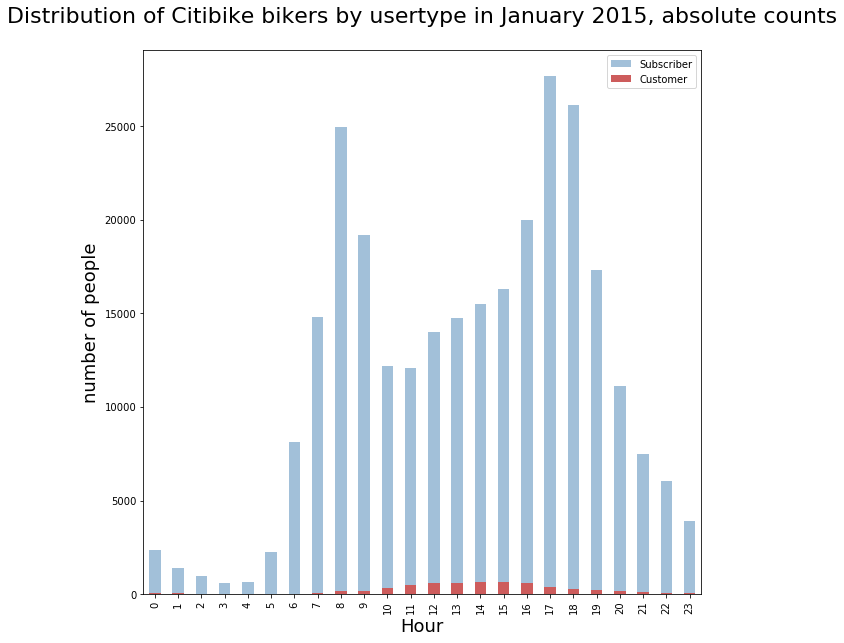

In [8]:
# plot the number of trips, separate Subscriber from Customer
fig = plt.figure(figsize=(10,10))
norm_w = 1
ax = (df['date'][df['usertype'] == 'Subscriber'].groupby(
        [df['date'].dt.hour]).count()).plot(kind="bar", color='SteelBlue', alpha=0.5, label='Subscriber')

norm_m = 1
ax = (df['date'][df['usertype'] == 'Customer'].groupby(
        [df['date'].dt.hour]).count()).plot(kind="bar", color='IndianRed', label='Customer')

plt.legend()
plt.xlabel("Hour", fontsize = 18)
plt.ylabel("number of people", fontsize = 18)
plt.title("Distribution of Citibike bikers by usertype in January 2015, absolute counts", fontsize=22, y=1.04)

## Figure 1a: Distribution of Citibike bikers by usertype in January 2015, absolute counts

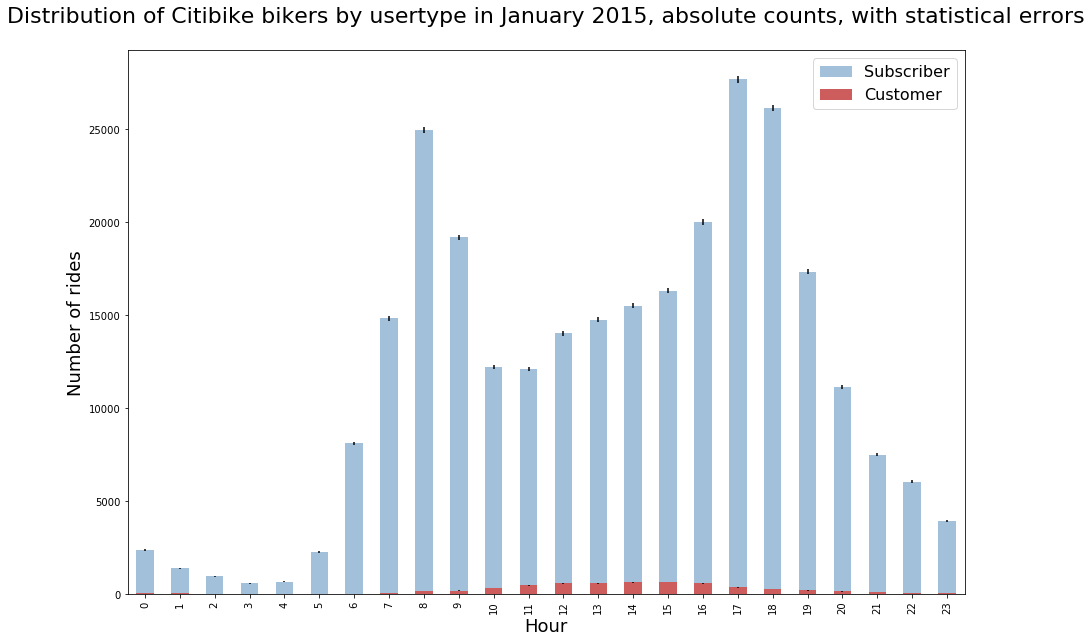

In [9]:
# add the sqrt(N)
fig=plt.figure(figsize=(15,10))

countsSubs = df.date[df.usertype == 'Subscriber'].groupby([df['date'].dt.hour]).count()
normSubs = 1
errorSubs = np.sqrt(countsSubs)
ax=((countsSubs) / normSubs).plot(kind="bar", alpha=0.5, color='SteelBlue',  yerr=[
            ((errorSubs) / normSubs, (errorSubs) / normSubs)], label='Subscriber')


countsCust = df.date[df.usertype == 'Customer'].groupby([df['date'].dt.hour]).count()
normCust = 1
errorCust=np.sqrt(countsCust)
((countsCust) / normCust).plot(kind="bar", yerr=[
        ((errorCust) / normCust, (errorCust) / normCust)], color='IndianRed', label='Customer')
ax.set_ylabel ("Number of rides", fontsize = 18)
ax.set_xlabel ("Hour", fontsize = 18)
plt.legend(['Subscriber','Customer'],fontsize=16)
plt.title("Distribution of Citibike bikers by usertype in January 2015, absolute counts, with statistical errors", 
          fontsize=22, y=1.04)

## Figure 1b: Distribution of Citibike bikers by usertype in January 2015, absolute counts, with statistical errors

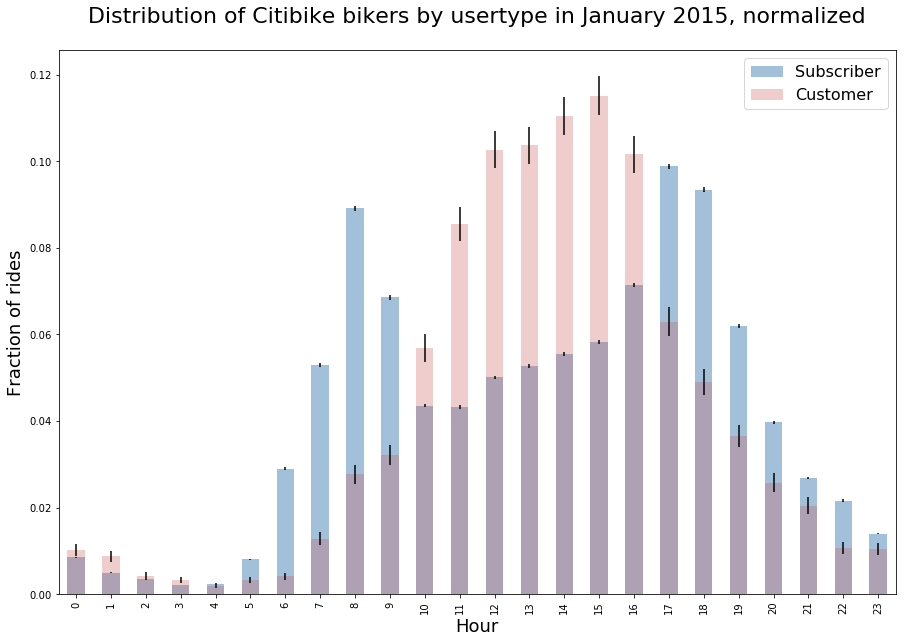

In [10]:
# normalize the distribution
fig = plt.figure(figsize=(15,10))

normSubs = countsSubs.sum()
errorSubs = np.sqrt(countsSubs)
ax = ((countsSubs) / normSubs).plot(kind="bar", color='SteelBlue', alpha=0.5,  
                           yerr=[((errorSubs) / normSubs, (errorSubs) / normSubs)], 
                           label='Subscriber')

normCust = countsCust.sum()
ax = ((countsCust) / normCust).plot(kind="bar", alpha=0.3, 
                                yerr=[((errorCust) / normCust, (errorCust) / normCust)], 
                                color='IndianRed', label='Customer')

ax.set_ylabel ("Fraction of rides", fontsize = 18)
ax.set_xlabel ("Hour", fontsize = 18)
plt.title("Distribution of Citibike bikers by usertype in January 2015, normalized", fontsize=22, y=1.04)
plt.legend(['Subscriber','Customer'], fontsize=16)

## Figure 2: Distribution of Citibike bikers by usertype in January 2015, normalized

we can add up the week and weekend days, then this becomes a test of proportions, (like the one seen in the [employment notebook](https://github.com/fedhere/UInotebooks/blob/master/hypothesistesting/effectivenes%20of%20NYC%20Post-Prison%20Employment%20Programs.save.ipynb))

__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
# This is the portion of Assignment 2 that should be done by the week of September 26.  The rest will be due the following week.
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________


## Set up the test of proportions
### I need the fraction of women that bikes during the weekdays and the fraction that bikes during weekends, and the same for men

In [11]:
workHour = 0
for i in range(9,18):
    workHour += timeuse[i] 
workHour

156115

In [12]:
offWork = timeuse.sum() - workHour
offWork

129437

In [13]:
fig = pl.figure(figsize(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_xticks([])
ax2.set_xticks([])

week_w = sum(counts_w[:-2]) * 1.0 / norm_w  #fraction of women riding on week days
weekend_w = sum(counts_w[-2:]) * 1.0 / norm_w  #fraction of women riding on weekends
eweek_w = np.sqrt(sum(error_w[:-2]**2)) / norm_w  #error on fraction number of women riding on week days
eweekend_w = np.sqrt(sum(error_w[-2:]**2)) / norm_w #error on fraction number of women riding on weekends

#same nomenclature as above
week_m = sum(counts_m[:-2]) * 1.0 / norm_m
weekend_m = sum(counts_m[-2:]) * 1.0 / norm_m
eweek_m = np.sqrt(sum(error_m[:-2]**2)) / norm_m
eweekend_m = np.sqrt(sum(error_m[-2:]**2)) / norm_m

print("Men: week:{0:.3f}, weekend:{1:.3f}, weekend error:{2:.3f}, weekend error:{3:.3f}"\
      .format(week_m, weekend_m, eweek_m, eweekend_m))
print("Women: week:{0:.3f}, weekend:{1:.3f}, weekend error:{2:.3f}, weekend error:{3:.3f}"\
      .format(week_w, weekend_w, eweek_w, eweekend_w))

ax1.errorbar([0.4], [week_m], yerr=[eweek_m], fmt='o', label='men')
ax1.errorbar([0.2], [week_w], yerr=[eweek_w], fmt='o', label='women')
ax1.set_xlim(0, 0.5)
ax2.errorbar([0.4], [weekend_m], yerr=[eweekend_m], fmt='o', label='men')
ax2.errorbar([0.2], [weekend_w], yerr=[eweekend_w], fmt='o', label='women')
ax1.set_xlim(0, 0.5)
ax1.set_title("week days")
ax2.set_title("weekends")
ax2.set_ylabel("Fraction of normalized rides by gender")
ax1.set_ylabel("Fraction of normalized rides by gender")

pl.xlim(-0.5, 1.5)
pl.legend(fontsize = 20)

NameError: name 'pl' is not defined

## Figure 3: Fraction of Citibike bikers per gender in January 2016 for week days (left) and weekends (right)

### Is the percentage of women that ride on weekends lower or equal to that of man?
## The statistics is: 
# $z = \frac{(p_0 - p_1)}{SE} $
# $p =\frac{p_0  n_0 + p_1  n_1}{n_0+n_1}$
# $SE = \sqrt{ p  ( 1 - p )  (\frac{1}{n_0} + \frac{1}{n_1}) }$
## and in this notation 
# $p_0 = \frac{W_{\mathrm{weekend}}}{W_{\mathrm{week}}}$
### and 
# $p_1 = \frac{M_{\mathrm{weekend}}}{M_{\mathrm{week}}}$


In [ ]:
P0mP1 = weekend_w - weekend_m
print ("difference between man and women on weekend: ", P0mP1)
if P0mP1 <= 0:
    # we are done...
    print("In accordance with Null Hypothesis")
else:
    # morework to do
    print ("We must check the significance before we reject the Null Hypothesis")

### Is this difference statistically significant?

In [ ]:
# defining the functions that calculate the statistics
# the lambda style definition is NOT APPROVED BY PEP8 and you should avoind it
# but I am putting it here since you may encounter it in your coding life.
# confront the equation in the markdown cell above with these function to understand as they work

p = lambda p0, p1, n0, n1: (p0 * n0 + p1 * n1) / (n0 + n1)
se = lambda p, n0, n1: np.sqrt(p * (1 - p) * (1.0 / n0 + 1.0 / n1)) #standard error
zscore = lambda p0, p1, s : (p0 - p1) / s

# calculations

sp_stdev_mw = se(p(weekend_w, weekend_m, norm_w, norm_m), norm_w, norm_m)
# print (sp_stdev_mw)
z = zscore(weekend_w, weekend_m, sp_stdev_mw)
print ("The z statistics is %.2f"%z) 

## The largest number reported in  z stats tables is (thpically) 3, which gives  a p value
## $p <0.0002$, which is smaller then my chosen $\alpha=0.05$ - so yes, it is statistically significant (by a lot!)

# We reject the Null Hypothesis that man are more likely to commute than women $p< 0.05$


__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________

# Check the robustness of your answer with another citibike dataset (unless you used all of the data at once!)

## Lets see if our test holds in the summer, when people clothes may get less in the way to riding

### notice that it is not very pythonic to just copy and paste code as I am doing here! Everything that needs to be done more than once should be done in a function. Why? Because that way if I make any changes I do not run the risk to forget to make the change in one of the spots! (Also it helps readability)

In [ ]:
datestring = '201506'
getCitiBikeCSV(datestring)

In [ ]:
df_06 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
df_06['date'] = pd.to_datetime(df_06.starttime)
df_06.head()

In [ ]:
df_06.drop(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year'], axis=1, inplace=True)


In [ ]:
df_06.head()

In [ ]:
fig=pl.figure(figsize(15,10))

counts_w06 = df_06.date[df_06.gender == 2].groupby([df_06.date.dt.weekday]).count()
norm_w06 = counts_w06.sum()
error_w06 = np.sqrt(counts_w06)

((counts_w06) / norm_w06).plot(kind="bar",color='IndianRed',  yerr=[
            ((error_w06) / norm_w06, (error_w06) / norm_w06)], label='women bikers, June')

counts_m06 = df_06.date[df_06.gender==1].groupby([df_06.date.dt.weekday]).count()
norm_m06 = counts_m06.sum()
error_m06 = np.sqrt(counts_m06)
ax=((counts_m06) / norm_m06).plot(kind="bar", alpha=0.5, 
                                  yerr=[((error_m06) / norm_m06, (error_m06) / norm_m06)], 
                                  color="SteelBlue", label='men bikers, June')
ax.xaxis.set_ticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize=20)
ax.set_ylabel ("Fraction of rides")
ax.set_xlabel ("Day of the week")


pl.legend(['women bikers','men bikers'],fontsize=20)

## Figure 4: Distribution of Citibike bikers by gender in June 2016, normalized

In [ ]:
fig=pl.figure(figsize(15,6))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
ax1.set_xticks([])
ax2.set_xticks([])

week_w06 = sum(counts_w06[:-2]) * 1.0 / norm_w06
weekend_w06 = sum(counts_w06[-2:])*1.0 / norm_w06
eweek_w06 = np.sqrt(sum(error_w06[:-2]**2)) / norm_w06
eweekend_w06 = np.sqrt(sum(error_w06[-2:]**2)) / norm_w06

week_m06 = sum(counts_m06[:-2]) * 1.0 / norm_m06
weekend_m06 = sum(counts_m06[-2:]) * 1.0 / norm_m06
eweek_m06 = np.sqrt(sum(error_m06[:-2]**2)) / norm_m06
eweekend_m06 = np.sqrt(sum(error_m06[-2:]**2)) / norm_m06

print("Men: week:{0:.3f}, weekend:{1:.3f}, weekend error:{2:.3f}, weekend error:{3:.3f}"\
      .format(week_m06, weekend_m06, eweek_m06, eweekend_m06))
print("Women: week:{0:.3f}, weekend:{1:.3f}, weekend error:{2:.3f}, weekend error:{3:.3f}"\
      .format(week_w06, weekend_w06, eweek_w06, eweekend_w06))

ax1.errorbar([0.2],[week_w06], yerr=[eweek_w06], fmt='o', label='women')
ax1.errorbar([0.4],[week_m06], yerr=[eweek_m06], fmt='o', label='men')
ax1.set_xlim(0,0.5)
ax2.errorbar([0.2],[weekend_w06], yerr=[eweekend_w06], fmt='o', label='women')
ax2.errorbar([0.4],[weekend_m06], yerr=[eweekend_m06], fmt='o', label='men')
ax1.set_xlim(0,0.5)
ax1.set_title("week days")
ax2.set_title("weekends")
ax2.set_ylabel("Fraction of normalized rides by gender")
ax1.set_ylabel("Fraction of normalized rides by gender")

pl.xlim(-0.5,1.5)
pl.legend(fontsize=20)


sp_stdev_mw06 = se(p(weekend_w06, weekend_m06, norm_w06, norm_m06), norm_w06, norm_m06)
# print (sp_stdev_mw)
z06 = zscore(weekend_w06, weekend_m06, sp_stdev_mw06)
print ("The z statistics is %.2f"%z) 

## The z statstic is even larger in the Summer! Larger z means farther into the significance reagion
# We reject the Null Hypothesis that man are more likely to commute than women $p< 0.05$ in the summer aswell, 
# and my hypothesis is robust to seasonality


# BUT inreality ... there are many moreriders in the summer, 
# so the increase in statistical significance may not be due to a larger effect, but not to a larger effect.
# Let's check the _effect size_: 
# there are 2 formulae I find in the literature
# $r = \frac{z}{\sqrt{(n_0+n_1)}}$
# and
# $h =  2 (\arcsin \sqrt{p_0} -  \arcsin \sqrt{p_1} )$. https://en.wikipedia.org/wiki/Cohen%27s_h

In [ ]:
r = lambda z, n0, n1 : z / np.sqrt(n0+n0)
h = lambda p0, p1: 2 * (np.arcsin(np.sqrt(p0)) - np.arcsin(np.sqrt(p1)))

In [ ]:
r01 = r(z, norm_w, norm_m)
r06 = r(z06, norm_w06, norm_m06)
print (r01, r06)

In [ ]:
h01 = h(weekend_w, weekend_m)
h06 = h(weekend_w06, weekend_m06)
print (h01, h06)

# In all these cases we have SMALL EFFECT SIZE, and in both cases slightly smaller for the summer data (although the statistiocal significance is slightly higher)